In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import spacy
import string
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
from sklearn.metrics import jaccard_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import hdbscan
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora.dictionary import Dictionary
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from gensim.corpora import Dictionary
from transformers import BigBirdTokenizer, BigBirdModel, AutoModel, AutoTokenizer, AutoModelForPreTraining, AutoModelForMaskedLM, ReformerModel, ReformerTokenizer
import torch
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import ZeroShotClassification
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.model_selection import ParameterGrid
import optuna



In [3]:
ds = pd.read_csv('student_loan_data.csv')
print(ds.shape)
ds.head()

(8185, 19)


Date received       Product                     Sub-product  \
0    2023-12-07  Student loan  Federal student loan servicing   
1    2023-12-29  Student loan  Federal student loan servicing   
2    2023-11-13  Student loan  Federal student loan servicing   
3    2023-11-13  Student loan  Federal student loan servicing   
4    2023-10-17  Student loan  Federal student loan servicing   

                                  Issue  \
0  Dealing with your lender or servicer   
1  Dealing with your lender or servicer   
2  Dealing with your lender or servicer   
3  Dealing with your lender or servicer   
4  Dealing with your lender or servicer   

                                     Sub-issue  \
0                Problem with customer service   
1  Trouble with how payments are being handled   
2     Received bad information about your loan   
3                                    Co-signer   
4                Problem with customer service   

                        Consumer complaint narrative  \
0  In took 1 quarter at XXXX XXXX. In that quarte...   
1  My student loan provider is currently Nelnet. ...   
2  on XX/XX/25 I went to student aid.gov and appl...   
3  In response to claim number XXXX Nelnet employ...   
4  I am an authorized payor on my son 's Nelnet a...   

                             Company public response  \
0  Company believes it acted appropriately as aut...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                          Company State ZIP code Tags  \
0                          MOHELA    OH    457XX  NaN   
1                    Nelnet, Inc.    IA    50265  NaN   
2  Maximus Federal Services, Inc.    CA    955XX  NaN   
3                    Nelnet, Inc.    TN    37115  NaN   
4                    Nelnet, Inc.    NC    284XX  NaN   

  Consumer consent provided? Submitted via Date sent to company  \
0           Consent provided           Web           2023-12-07   
1           Consent provided           Web           2023-12-29   
2           Consent provided           Web           2023-11-13   
3           Consent provided           Web           2023-11-13   
4           Consent provided           Web           2023-10-17   

  Company response to consumer Timely response?  Consumer disputed?  \
0      Closed with explanation              Yes                 NaN   
1      Closed with explanation              Yes                 NaN   
2      Closed with explanation              Yes                 NaN   
3      Closed with explanation              Yes                 NaN   
4      Closed with explanation              Yes                 NaN   

   Complaint ID                                Processed Complaint  
0       7958117  took quarter xxxx xxxx. quarter subsidized loa...  
1       8080675  student loan provider currently nelnet. making...  
2       7844168  xx/xx/ went student aid.gov applied save progr...  
3       7844744  response claim number xxxx nelnet employee ( x...  
4       7712911  authorized payor son 's nelnet account. signin...

In [4]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

ds["Processed Complaint"] = ds["Processed Complaint"].apply(lambda text: lemmatize_words(text))
ds.head()

Date received       Product                     Sub-product  \
0    2023-12-07  Student loan  Federal student loan servicing   
1    2023-12-29  Student loan  Federal student loan servicing   
2    2023-11-13  Student loan  Federal student loan servicing   
3    2023-11-13  Student loan  Federal student loan servicing   
4    2023-10-17  Student loan  Federal student loan servicing   

                                  Issue  \
0  Dealing with your lender or servicer   
1  Dealing with your lender or servicer   
2  Dealing with your lender or servicer   
3  Dealing with your lender or servicer   
4  Dealing with your lender or servicer   

                                     Sub-issue  \
0                Problem with customer service   
1  Trouble with how payments are being handled   
2     Received bad information about your loan   
3                                    Co-signer   
4                Problem with customer service   

                        Consumer complaint narrative  \
0  In took 1 quarter at XXXX XXXX. In that quarte...   
1  My student loan provider is currently Nelnet. ...   
2  on XX/XX/25 I went to student aid.gov and appl...   
3  In response to claim number XXXX Nelnet employ...   
4  I am an authorized payor on my son 's Nelnet a...   

                             Company public response  \
0  Company believes it acted appropriately as aut...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                          Company State ZIP code Tags  \
0                          MOHELA    OH    457XX  NaN   
1                    Nelnet, Inc.    IA    50265  NaN   
2  Maximus Federal Services, Inc.    CA    955XX  NaN   
3                    Nelnet, Inc.    TN    37115  NaN   
4                    Nelnet, Inc.    NC    284XX  NaN   

  Consumer consent provided? Submitted via Date sent to company  \
0           Consent provided           Web           2023-12-07   
1           Consent provided           Web           2023-12-29   
2           Consent provided           Web           2023-11-13   
3           Consent provided           Web           2023-11-13   
4           Consent provided           Web           2023-10-17   

  Company response to consumer Timely response?  Consumer disputed?  \
0      Closed with explanation              Yes                 NaN   
1      Closed with explanation              Yes                 NaN   
2      Closed with explanation              Yes                 NaN   
3      Closed with explanation              Yes                 NaN   
4      Closed with explanation              Yes                 NaN   

   Complaint ID                                Processed Complaint  
0       7958117  take quarter xxxx xxxx. quarter subsidize loan...  
1       8080675  student loan provider currently nelnet. make p...  
2       7844168  xx/xx/ go student aid.gov apply save program s...  
3       7844744  response claim number xxxx nelnet employee ( x...  
4       7712911  authorize payor son 's nelnet account. sign po...

In [10]:
pd.options.mode.chained_assignment = None

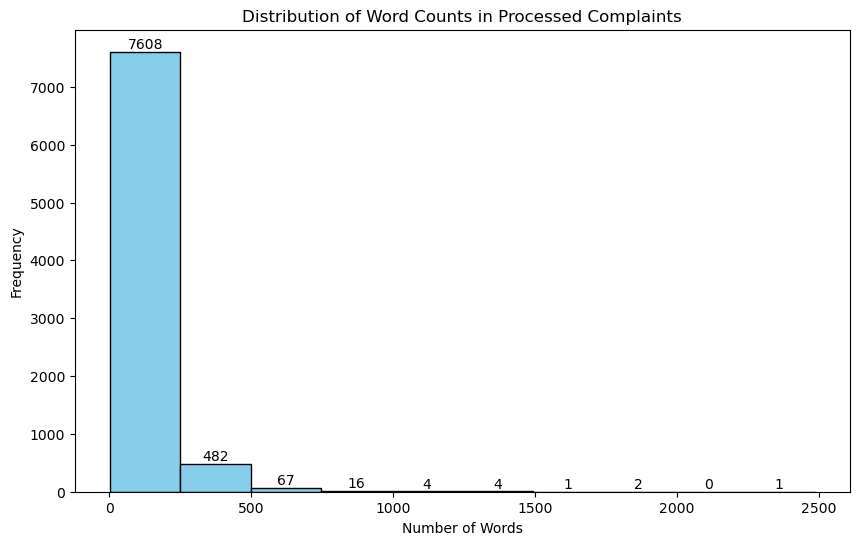

In [12]:
# Calculate the number of words in each complaint
ds['Word Count'] = ds['Processed Complaint'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(ds['Word Count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Processed Complaints')

# Adding frequency labels on top of each bar
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             n[i], 
             int(n[i]), 
             ha='center', 
             va='bottom')

plt.show()


In [14]:
# Load and preprocess your dataset
documents = ds['Processed Complaint'].tolist()
print(len(documents))

8185


In [16]:
# Function to calculate a basic topic diversity score
def calculate_topic_diversity(topic_model):
    unique_words = set()
    total_words = 0
    for topic in topic_model.get_topics().values():
        words = [word for word, _ in topic]  # Extract top words
        unique_words.update(words)
        total_words += len(words)
    diversity_score = len(unique_words) / total_words
    return diversity_score
def sigmoid(x):
    """
    Sigmoid function for standardizing values to (0, 1).
    """
    return 1 / (1 + np.exp(-1.0456*(x+5.60)))

def calculate_and_average_coherence_scores(topic_model, texts, dictionary):
    """
    Calculate C_v, C_umass, and C_npmi coherence scores for a BERTopic model,
    standardize them to [0, 1], and return the average standardized score.
    
    Parameters:
        topic_model: BERTopic model instance
        texts: List of preprocessed texts (list of tokenized words per document)
        dictionary: Gensim dictionary created from the texts
        
    Returns:
        Average standardized coherence score
    """
    # Extract topics from BERTopic
    topics = [[word for word, _ in topic] for topic in topic_model.get_topics().values()]

    # Define coherence metrics
    metrics = {
        "c_v": {"min": 0, "max": 1},  # C_v naturally falls in [0, 1]
        "u_mass": "sigmoid",          # Use sigmoid for C_umass
        "c_npmi": {"min": -1, "max": 1},  # C_npmi falls in [-1, 1]
    }

    # Calculate coherence scores
    coherence_scores = {}
    for metric, bounds in metrics.items():
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=metric)
        score = coherence_model.get_coherence()

        if metric == "u_mass":
            # Use sigmoid for standardization of C_umass
            standardized_score = sigmoid(score)  
        else:
            # Standardize using min-max scaling
            standardized_score = (score - bounds["min"]) / (bounds["max"] - bounds["min"])
            standardized_score = max(0, min(1, standardized_score))  # Clip to [0, 1]

        coherence_scores[metric] = standardized_score

    # Average of standardized coherence scores
    average_standardized_score = np.mean(list(coherence_scores.values()))

    return average_standardized_score
# Function to calculate a Cosine Similarity
def calculate_topic_representativeness(topic_embeddings, document_embeddings):
    """
    Calculate Topic Representativeness using Cosine Similarity.

    Parameters:
        topic_embeddings: 2D array (n_topics, embedding_dim) of topic embeddings.
        document_embeddings: 2D array (n_documents, embedding_dim) of document embeddings.

    Returns:
        Standardized cosine similarity score in [0, 1].
    """
    # Compute cosine similarity between topic and document embeddings
    similarities = cosine_similarity(topic_embeddings, document_embeddings)
    
    # Take the mean of maximum similarity for each document
    average_similarity = np.mean(np.max(similarities, axis=0))
    
    # Standardize cosine similarity from [-1, 1] to [0, 1]
    standardized_similarity = (average_similarity + 1) / 2
    return standardized_similarity

# Function to calculate Silhouette Score
def calculate_silhouette_score(document_embeddings, topic_labels):
    """
    Calculate Silhouette Score and standardize it.

    Parameters:
        document_embeddings: 2D array of document embeddings.
        topic_labels: 1D array of assigned topic labels for documents.

    Returns:
        Standardized silhouette score in [0, 1].
    """
    score = silhouette_score(document_embeddings, topic_labels)
    # Standardize silhouette score from [-1, 1] to [0, 1]
    standardized_score = (score + 1) / 2
    return standardized_score
    





In [18]:
results = {}
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)
umap_model = UMAP(
        n_neighbors=21,
        min_dist=0.45313554620854735,
        n_components=8,
        metric='manhattan',
        random_state=42,
    )
Spectral_model = SpectralClustering(n_clusters=5,eigen_solver='amg',affinity='rbf',assign_labels='kmeans')
representation_model = MaximalMarginalRelevance(
        diversity=0.7168968007367521, top_n_words=9
    )
topic_model = BERTopic(
        embedding_model=AutoModel.from_pretrained("allenai/longformer-base-4096"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model
    )
topics, probs = topic_model.fit_transform(documents)
topic_info = topic_model.get_topic_info()
topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
sentence_transformer_model = topic_model.embedding_model
topic_embeddings = topic_model.topic_embeddings_
document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
# Use consistent `documents` for `get_document_info`
document_info = topic_model.get_document_info(documents)
topic_labels = document_info["Topic"].values

diversity_score = calculate_topic_diversity(topic_model)
representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
silhouette = calculate_silhouette_score(document_embeddings, topic_labels)
num_topics = topic_info_df.shape[0]
# Combine metrics into a single score
final_score = coherence_score+diversity_score+representativeness_score+silhouette
with pd.ExcelWriter("topic_modeling_para_tunning_5.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", "Representation Models",
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Topic Representativeness","Silhouette Score","Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    summary_df = pd.DataFrame({
                            "Embedding Model": "longformer",
                            "Dimensionality Reduction": "umap",
                            "Clustering Method": "Spectral",
                            "Representation Models":"MaximalMarginalRelevance",
                            "Number of Topics": [num_topics],
                            "Topic Diversity Score": [diversity_score],
                            "Coherence Score": [coherence_score],
                            "Topic Representativeness": [representativeness_score],
                            "Silhouette Score": [silhouette],
                            "Total Score": [final_score]
                        })
    sheet_name_0 = "Summary"
    summary_df.to_excel(writer,  sheet_name="Summary", startrow=1,index=False, header=False)
    topic_info_df.to_excel(writer, sheet_name="Summary",startrow=len(summary_df) + 2, index=False)
    

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

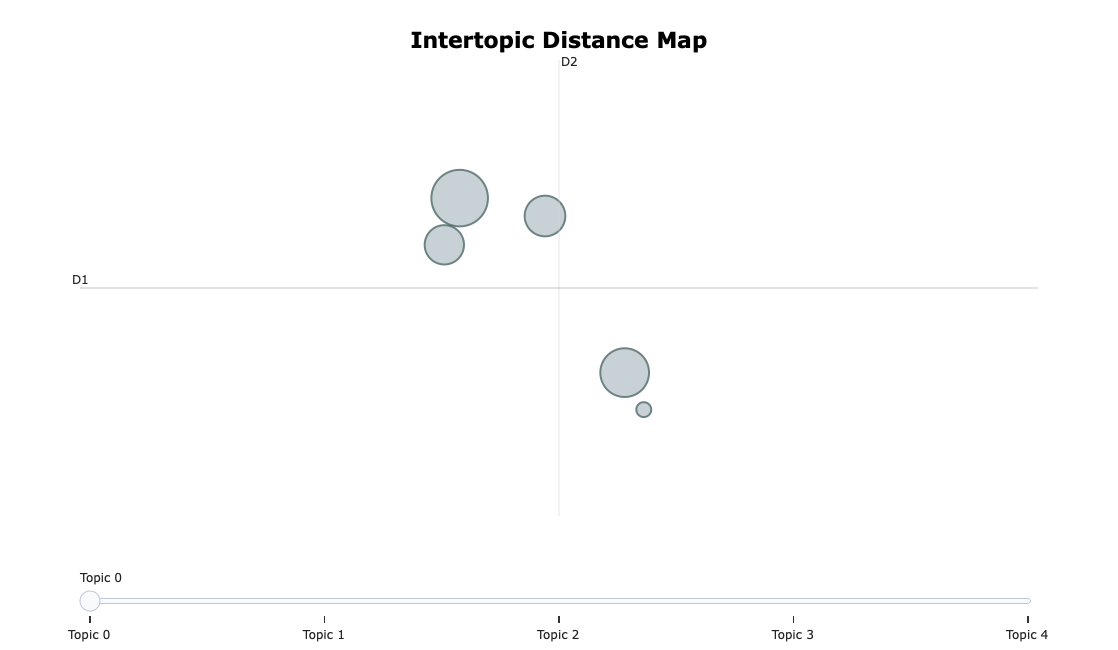

In [19]:
# Generate the topic visualization
topic_model.visualize_topics()




2024-12-19 19:33:31,055 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 714) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


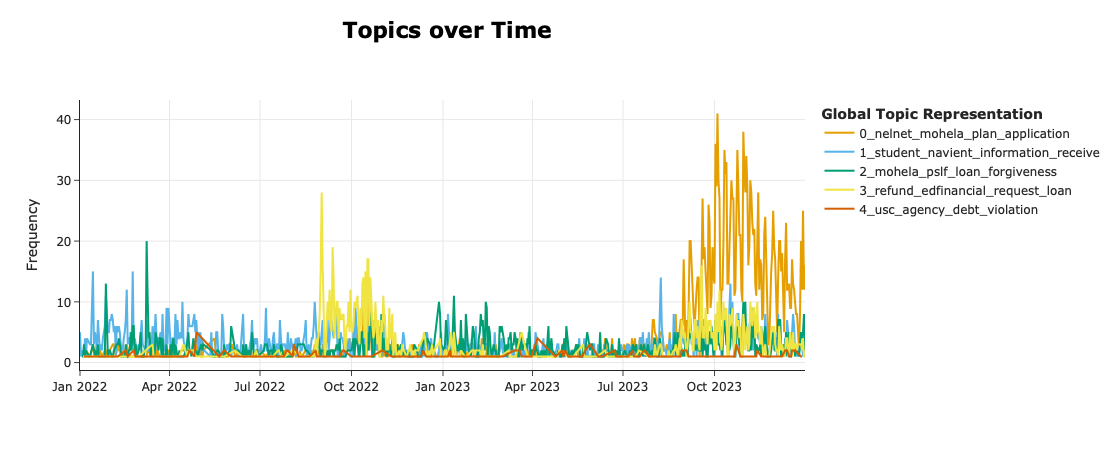

In [34]:
timestamps=ds['Date received'].tolist()
topics_over_time=topic_model.topics_over_time(documents,timestamps)
topic_model.visualize_topics_over_time(topics_over_time)

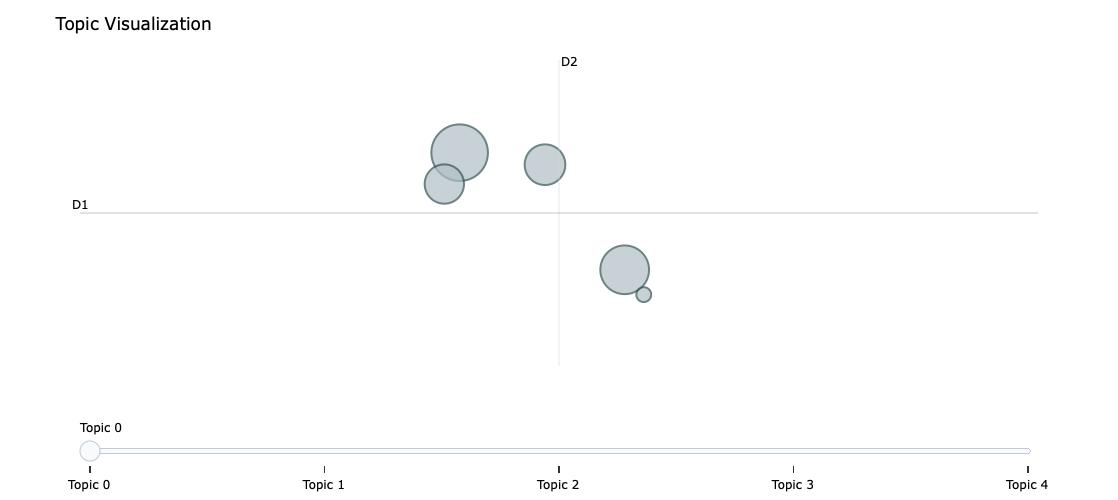

In [57]:
import plotly.graph_objects as go

# Generate the topic visualization
topic_visualization = topic_model.visualize_topics()

# Customize layout to modify the shape, size, and appearance of the graph
topic_visualization.update_layout(
    title="Topic Visualization",
    title_x=0.5,  # Center the title
    width=1000,  # Set width
    height=500,  # Set height
    showlegend=True,  # Display legend
    plot_bgcolor="white",  # Set background color
    paper_bgcolor="white",  # Set paper background color
    font=dict(size=12, color='black'),  # Customize font size and color
    xaxis=dict(showgrid=False),  # Hide gridlines on x-axis
    yaxis=dict(showgrid=False),  # Hide gridlines on y-axis
)



# Show the updated plot
topic_visualization.show()

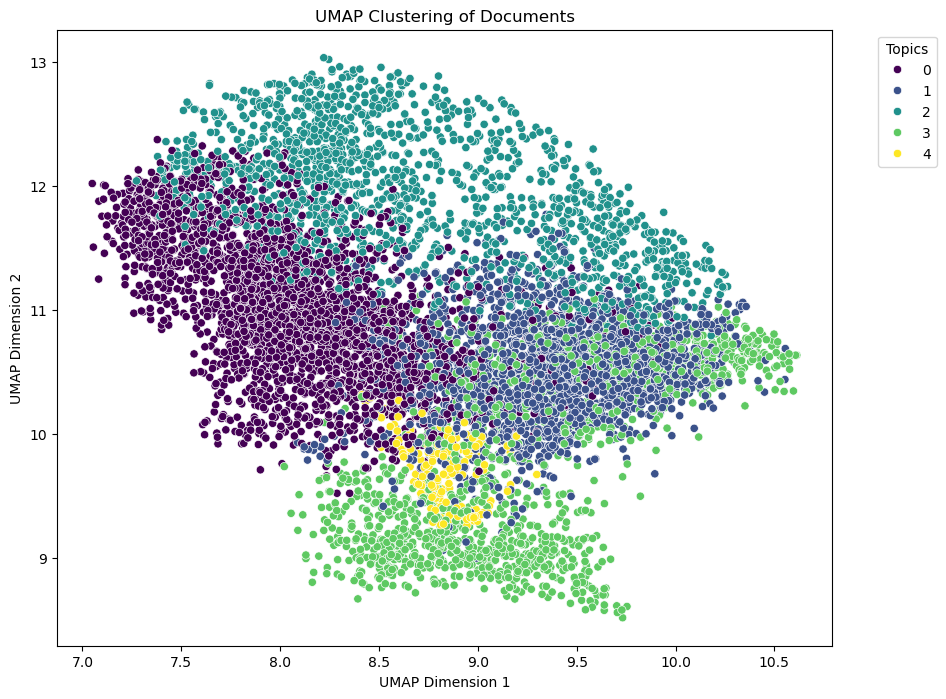

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Retrieve UMAP embeddings (if already computed) or compute them
umap_embeddings = topic_model.umap_model.fit_transform(document_embeddings)

# Plotting UMAP with topic labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=topic_labels,
    palette="viridis",
    legend="full"
)
plt.title("UMAP Clustering of Documents")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

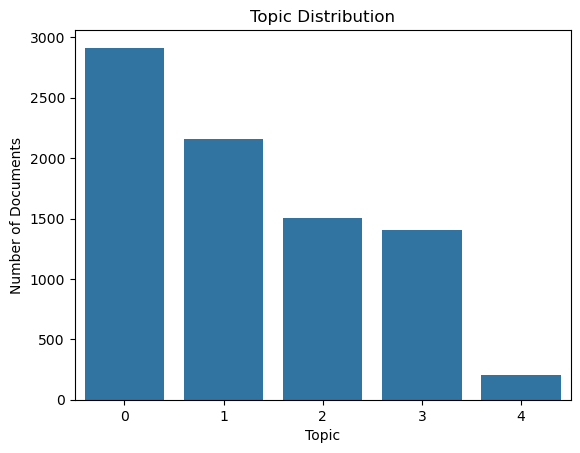

In [11]:
#Topic Distribution
topic_counts = topic_info_df['Count']  # Assuming 'Count' column exists in `topic_info_df`
sns.barplot(x=topic_info_df['Topic'], y=topic_counts)
plt.title("Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.show()

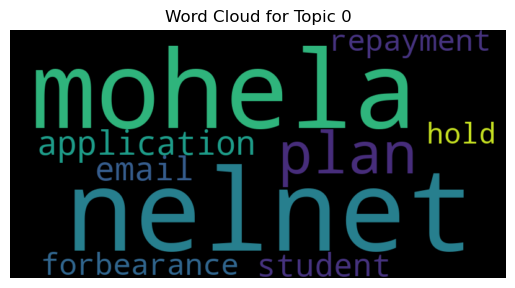

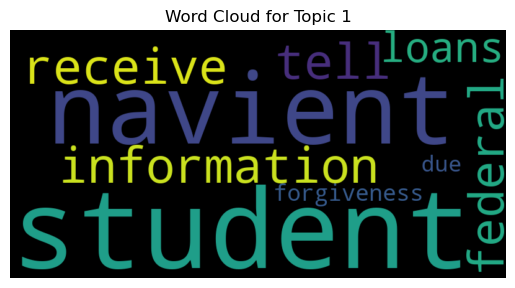

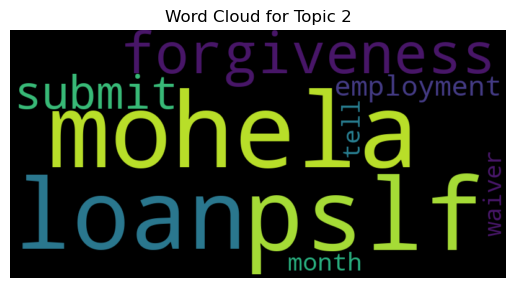

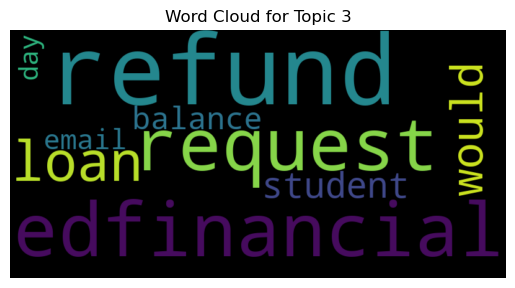

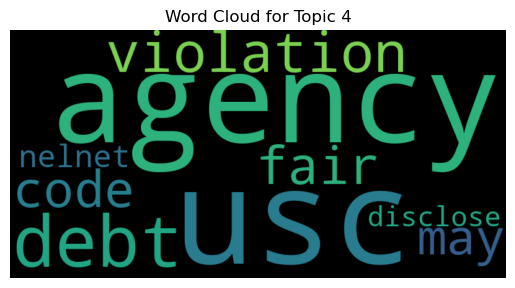

In [12]:
#Word Clouds for Topics
from wordcloud import WordCloud

for topic_id in topic_info_df['Topic']:
    words = topic_model.get_topic(topic_id)  # Retrieve words for the topic
    word_dict = {word[0]: word[1] for word in words}
    wc = WordCloud(width=800, height=400).generate_from_frequencies(word_dict)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}")
    plt.show()

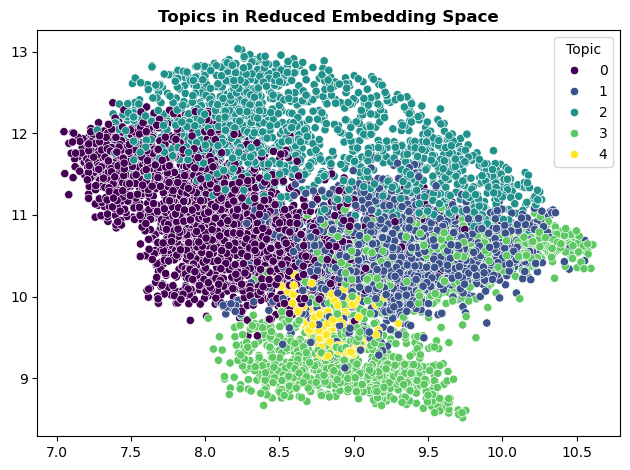

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# UMAP embeddings for visualization
umap_embeddings = topic_model.umap_model.transform(document_embeddings)
topic_ids = document_info["Topic"]  # Get topic assignment for each document

# Create scatter plot
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=topic_ids, palette="viridis")

# Title with 32-point size and bold
plt.title("Topics in Reduced Embedding Space", fontweight='bold')

# Adjusting the plot layout and exporting the graph
plt.tight_layout()
plt.savefig("topic_embeddings.png")  # Export to PNG file
plt.show()

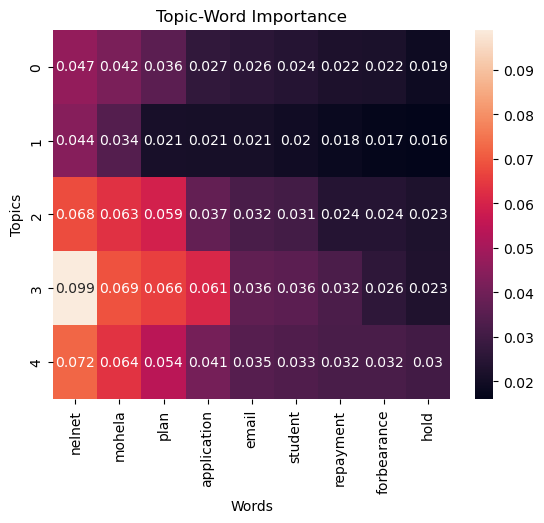

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract word importance for the first 10 words of each topic
word_importance = np.array([
    [word[1] for word in topic_model.get_topic(topic_id)[:10]]
    for topic_id in topic_info_df['Topic']
])

# Extract word labels for the first 10 words of each topic (ensure they align with columns)
word_labels = [word[0] for word in topic_model.get_topic(0)[:10]]  # Assuming all topics have the same top 10 words

# Plot heatmap
sns.heatmap(word_importance, annot=True, xticklabels=word_labels, yticklabels=topic_info_df['Topic'])
plt.title("Topic-Word Importance")
plt.xlabel("Words")
plt.ylabel("Topics")
plt.show()


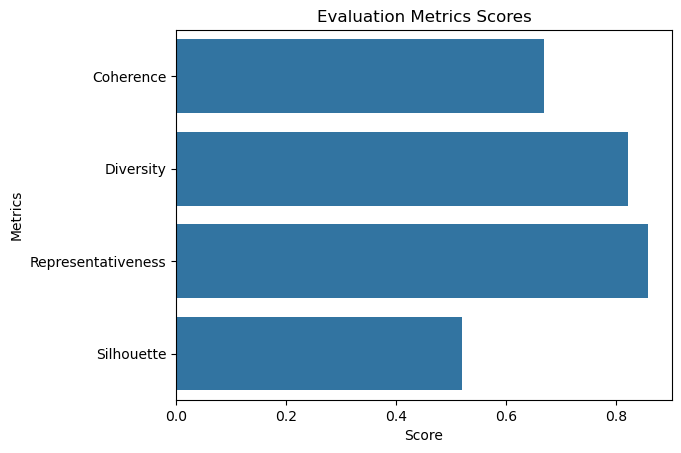

In [15]:
metrics = ["Coherence", "Diversity", "Representativeness", "Silhouette"]
scores = [coherence_score, diversity_score, representativeness_score, silhouette]
sns.barplot(x=scores, y=metrics)
plt.title("Evaluation Metrics Scores")
plt.xlabel("Score")
plt.ylabel("Metrics")
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
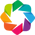

:Chord   [start,end]

In [16]:
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts
from sklearn.metrics.pairwise import cosine_similarity

hv.extension('bokeh')

# Step 1: Compute Topic Similarity Matrix
# Use topic embeddings from BERTopic to calculate cosine similarity
topic_embeddings = topic_model.topic_embeddings_
num_topics = len(topic_embeddings)  # Number of topics
topic_similarity_matrix = cosine_similarity(topic_embeddings)

# Optional: Normalize the similarity matrix to improve clarity
np.fill_diagonal(topic_similarity_matrix, 0)  # Remove self-loops for clarity
topic_similarity_matrix = (topic_similarity_matrix - topic_similarity_matrix.min()) / \
                          (topic_similarity_matrix.max() - topic_similarity_matrix.min())

# Step 2: Convert to DataFrame for Better Handling
topics = topic_info_df["Topic"].values  # Extract topic IDs
topic_similarity_df = pd.DataFrame(topic_similarity_matrix, index=topics, columns=topics)

# Step 3: Create a Chord Diagram Data Source
# Create edges/links between topics based on similarity
threshold = 0.1  # Filter out weak connections
links = [
    (topic_i, topic_j, topic_similarity_matrix[i, j])
    for i, topic_i in enumerate(topics)
    for j, topic_j in enumerate(topics)
    if topic_similarity_matrix[i, j] > threshold
]

# Create nodes with labels
nodes = [(topic, f"Topic {topic}") for topic in topics]

# Step 4: Create the Chord Diagram with Holoviews
chord_data = hv.Chord((links, hv.Dataset(nodes, 'index')))

# Step 5: Visualize Chord Diagram
chord_data.opts(
    opts.Chord(
        labels='label',
        cmap='Category20',
        edge_color='source',
        node_color='index',
        node_size=10,
        width=800,
        height=800,
        title="Topic Relationships (Chord Diagram)"
    )
)